# Facial Keypoints Recognition
6 December 2017
Harry Xu, Chet Gutwein, Noah Randolph

This notebook is based on the [Kaggle competition](https://www.kaggle.com/c/facial-keypoints-detection) to acheive the lowest root mean squared error (RMSE) classifying facial keypoint locations in digital grayscale images. Facial keypoints recognition is a crucial component of a broad set of applications that utilize digital faces, such as medical diagnosis research, biometric security screening, and social media camera apps. Training and tuning models for keypoint recognition is computationally demanding due to the multiple facial points to classify, the large number of total features (each image pixel is a feature), continuous data in each feature, and the need for a large training set. 

The x and y position of 15 facial keypoints in an image result in 30 columns of label names and 30 points with pixel locations to correctly classify for each test image.

The text below documents our efforts to acheive as low of a RMSE as possible. To run the code, you should download the data files [here](https://www.kaggle.com/c/facial-keypoints-detection/data).

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sb
import math
from IPython.display import display, clear_output
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.filters import gaussian_filter

## need to pip install this to read in images, not necessary except for last cell
import imageio

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

# set random seed to achieve same results each time
np.random.seed(23)

### Object to Hold Our Training, Dev and Test Data as Well as Simple Methods to Preprocess Data

We took an object oriented approach to programming the project, which kept most code blocks small and simple.

In [2]:
class FacialKeypoints(object):
    
    def __init__(self):
        self.train_csv = pd.read_csv("training.csv")
        self.test_csv = pd.read_csv("test.csv")
        self.sample_csv = pd.read_csv("SampleSubmission.csv")
        self.ID_csv = pd.read_csv("IdLookupTable.csv")
        self.label_names = self.train_csv.columns.tolist()[:-1]
        self.dev_data_n, self.dev_labels_n, self.train_data_n, self.train_labels_n = self.create_training(self.train_csv)
        self.dev_data, self.dev_labels, self.train_data, self.train_labels = self.create_training(self.train_csv, nans=False)
        self.train_data_f, self.train_labels_f = self.flip_data(self.train_data), self.flip_labels(self.train_labels)
        self.test_data, _ = self._parse_data(self.test_csv)
    
    # the create_training module simplified selection of rows based on complete rows of data
    def create_training(self, train_csv, dev_size=1000, nans=True):
        if nans == False:
            train_csv = train_csv.dropna()
        data, labels = self._parse_data(train_csv)
        shuffle = np.random.permutation(np.arange(data.shape[0]))        
        data, labels              = data[shuffle], labels[shuffle]       # Shuffle the data
        dev_data, dev_labels      = data[:dev_size], labels[:dev_size]   # Splitting into dev and training
        train_data, train_labels  = data[dev_size:], labels[dev_size:]
        return dev_data, dev_labels, train_data, train_labels
    
    def plot_example(self, data, label, predicted_label=np.nan, legend=True):
        plt.imshow(data.reshape(96, 96), cmap='gray')
        plt.scatter(label[0::2], label[1::2], c='red', marker='x', label='actual')
        if np.all(np.isfinite(predicted_label)):
            plt.scatter(predicted_label[0::2], predicted_label[1::2], c='blue', marker='x', label='predicted')
        plt.axis('off')
        if legend:
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
        return
    
    # the score function is based on the Kaggle competition's scoring method, using RMSE
    def score(self, y_pred, y_actual):
        return np.sqrt(mean_squared_error(y_actual, y_pred))
    
    # blurring data by replacing pixel values with the mean of the surrounding pixels reduces risk of overfitting
    def blur_data(self, data):
        data = data.reshape(data.shape[0], int(data.shape[1]**0.5), -1) 
        data = np.array([np.roll(np.roll(data, horizontal, axis=1), 
                                               vertical  , axis=2) 
                         for vertical in range(-1,2) for horizontal in range(-1,2)]
                       ).mean(axis=0)     
        return data.reshape(data.shape[0], -1)
    
    # module to produce .csv file to submit to Kaggle for scoring
    def submission_gen(self, predictions, file_name):
        df = pd.DataFrame(predictions, columns=self.train_csv.columns[:-1])
        pos = []
        for index, row in self.ID_csv.iterrows():
            pos.append((row['RowId'], df.iloc[row.ImageId - 1][row.FeatureName]))
        sub = pd.DataFrame(pos, columns=('RowId', 'Location'))
        sub.to_csv("./" + file_name + ".csv", index=False)
        return
    
    ## Various Methods to Create More Training Examples
    
    # replacing missing label values with the average of across all training images of the same facial position
    def average_nans(self, train_labels):
        df = pd.DataFrame(train_labels)
        return df.fillna(df.mean()).values
    
    # improvement is attempted by doubling the number of training images by simply flipping each image
    def flip_data(self, train_data):
        num_images = train_data.shape[0]
        train_data = train_data.reshape(num_images, 96, 96)[..., ::-1].flatten()
        return train_data.reshape(num_images, 9216)
    
    def flip_labels(self, train_labels):
        df = pd.DataFrame(train_labels.copy(), columns=self.label_names)
        df.loc[:, df.columns.str.contains('_x')] = df.loc[:, df.columns.str.contains('_x')].applymap(self._flip_axis)
        return df.values
        
    ## Helper Functions
    def _flip_axis(self, value, axis=47):
        if value >= axis:
            return axis - np.abs(value - axis)
        else:
            return axis + np.abs(value - axis)
    
    def _parse_data(self, data):
        labels = data.loc[:, data.columns != 'Image'].values   # column Image is the image data
        data = data['Image'].str.split()                       # image data comes as one long string
        data = np.vstack(data.apply(lambda row: np.asarray([int(n) for n in row])).values)
        data = data/255.0                                      # Rescale grayscale values to [0,1].
        return data, labels
    
    def rgb2gray(self, rgb):
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray
    
    pass

## Initialize the Object

In [3]:
self = FacialKeypoints()

## Missing Labels

We noticed that there are many examples that are missing a full label set. Out of the total 6049 examples, only 1140 have the full set of labels. Here is the percentage break out of each label

In [4]:
(self.train_csv.loc[:, self.train_csv.columns != 'Image'].count()/len(self.train_csv.index)).round(3)

left_eye_center_x            0.999
left_eye_center_y            0.999
right_eye_center_x           0.998
right_eye_center_y           0.998
left_eye_inner_corner_x      0.322
left_eye_inner_corner_y      0.322
left_eye_outer_corner_x      0.322
left_eye_outer_corner_y      0.322
right_eye_inner_corner_x     0.322
right_eye_inner_corner_y     0.322
right_eye_outer_corner_x     0.322
right_eye_outer_corner_y     0.322
left_eyebrow_inner_end_x     0.322
left_eyebrow_inner_end_y     0.322
left_eyebrow_outer_end_x     0.316
left_eyebrow_outer_end_y     0.316
right_eyebrow_inner_end_x    0.322
right_eyebrow_inner_end_y    0.322
right_eyebrow_outer_end_x    0.317
right_eyebrow_outer_end_y    0.317
nose_tip_x                   1.000
nose_tip_y                   1.000
mouth_left_corner_x          0.322
mouth_left_corner_y          0.322
mouth_right_corner_x         0.322
mouth_right_corner_y         0.322
mouth_center_top_lip_x       0.323
mouth_center_top_lip_y       0.323
mouth_center_bottom_

#### Plot Examples From Incomplete Labels

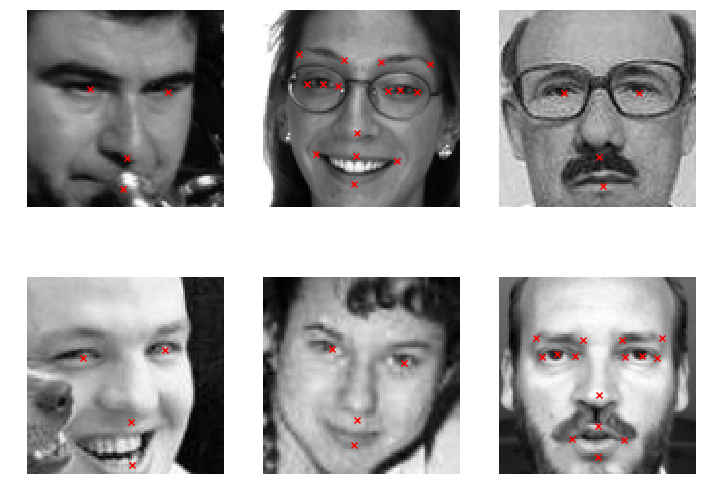

In [5]:
for n in range(1, 7):
    plt.subplot(2, 3, n)
    self.plot_example(self.train_data_n[n], self.train_labels_n[n], legend=False) 

#### Plot Examples From Complete Labels

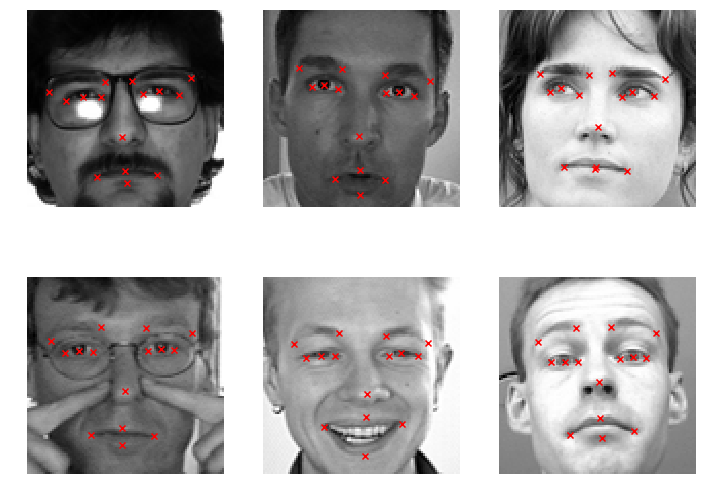

In [6]:
for n in range(1, 7):
    plt.subplot(2, 3, n)
    self.plot_example(self.train_data[n], self.train_labels[n], legend=False) 

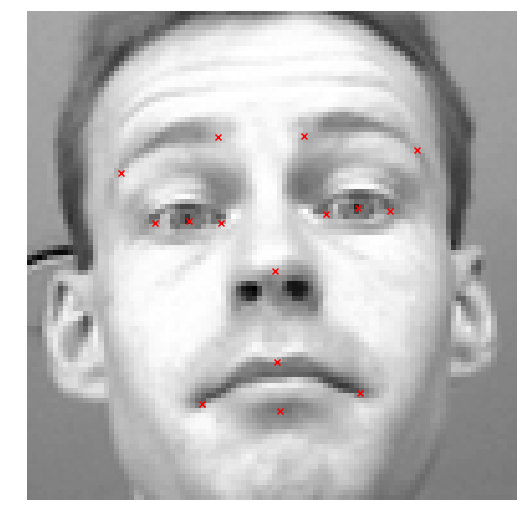

In [7]:
self.plot_example(self.train_data[n], self.train_labels[n], legend=False)

## Feature Engineering

### Blurring the Image
We attempt to improve test data scores by reducing the severity of overfitting to the training data. Below is an example of an image without blurring, and the same image after blurring.

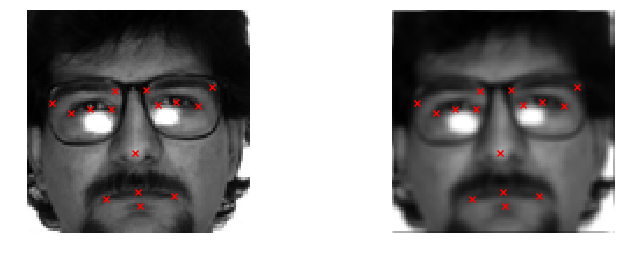

In [8]:
plt.subplot(2, 2, 1)
self.plot_example(self.train_data[1], self.train_labels[1], legend=False)
plt.subplot(2, 2, 2)
self.plot_example(self.blur_data(self.train_data)[1], self.train_labels[1], legend=False)

### Filling Missing Labels
Filling in missing facial keypoint labels with average values greatly increases the number of examples available for training.

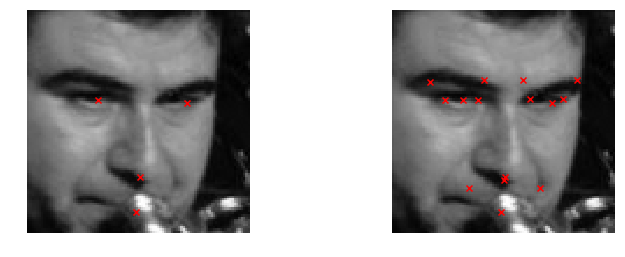

In [9]:
plt.subplot(2, 2, 1)
self.plot_example(self.train_data_n[1], self.train_labels_n[1], legend=False)
plt.subplot(2, 2, 2)
self.plot_example(self.train_data_n[1], self.average_nans(self.train_labels_n)[1], legend=False)

### Flipping the Image
Flipping the image doubles the number of examples for training, which should result in a more robust model.

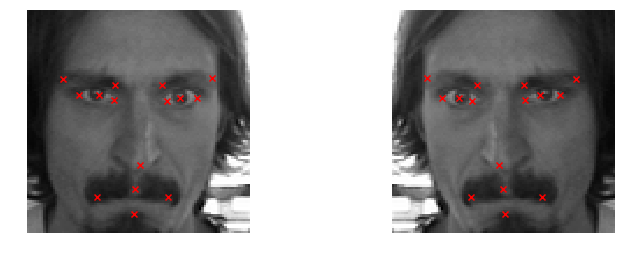

In [10]:
plt.subplot(2, 2, 1)
self.plot_example(self.train_data[0], self.train_labels[0], legend=False)
plt.subplot(2, 2, 2)
self.plot_example(self.train_data_f[0], self.train_labels_f[0], legend=False)

## K-NN
We decided to try a simple classifier to understand what is possible before jumping straight to the more advanced and more complicated options.

#### Using only the training data with complete set of labels

We used GridSearch to determine that the optimal value for n_neighbors=3 (see Appendix A).

In [13]:
data = self.train_data
labels = self.train_labels

print 'Our training set is size ' + str(data.shape[0])

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X=data, y=labels)

print 'RMSE on Dev Data of '
y_pred = knn.predict(self.dev_data) 
self.score(self.dev_labels, y_pred)

Our training set is size 1140
RMSE on Dev Data of 


2.5699609194515616

#### Using training data with missing Labels filled by average

In [14]:
data = self.train_data_n
labels = self.average_nans(self.train_labels_n)

print 'Our training set is size ' + str(data.shape[0])

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X=data, y=labels)

print 'RMSE on Dev Data of '
y_pred = knn.predict(self.dev_data) 
self.score(self.dev_labels, y_pred)

Our training set is size 6049
RMSE on Dev Data of 


1.8606199509164483

#### Using blurring and average _nans_

blur_data shifts the image 1 pixel in each direction and takes the mean, effectively returning a blurred image

average_nans replaces missing values/nans with the average value of that feature

In [15]:
data = self.blur_data(self.train_data_n)
labels = self.average_nans(self.train_labels_n)

print 'Our training set now has increased to ' + str(data.shape[0])

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X=data, y=labels)

print 'RMSE on Dev Data of '
y_pred = knn.predict(self.dev_data) 
self.score(self.dev_labels, y_pred)

Our training set now has increased to 6049
RMSE on Dev Data of 


1.8225472133057437

A score like this would put us within the top 16 on the Kaggle leaderboard. Unfortunately this result on the development data doesn't translate directly to the test data. We'll see more on overfitting below.

#### RMSE by Label

In [16]:
pd.DataFrame(np.sqrt(mean_squared_error(self.dev_labels, y_pred, multioutput='raw_values')), 
             columns=['RMSE'], index=self.label_names).sort_values('RMSE', ascending=False)

,RMSE
nose_tip_y,3.024229
mouth_center_bottom_lip_y,2.605217
mouth_center_top_lip_y,2.578482
mouth_left_corner_y,2.394495
mouth_right_corner_y,2.289124
mouth_left_corner_x,2.178618
mouth_right_corner_x,2.149628
right_eyebrow_outer_end_y,2.147477
left_eyebrow_outer_end_y,2.087928
left_eyebrow_outer_end_x,1.898402


#### Plot a Prediction

RMSE of 1.06332539756


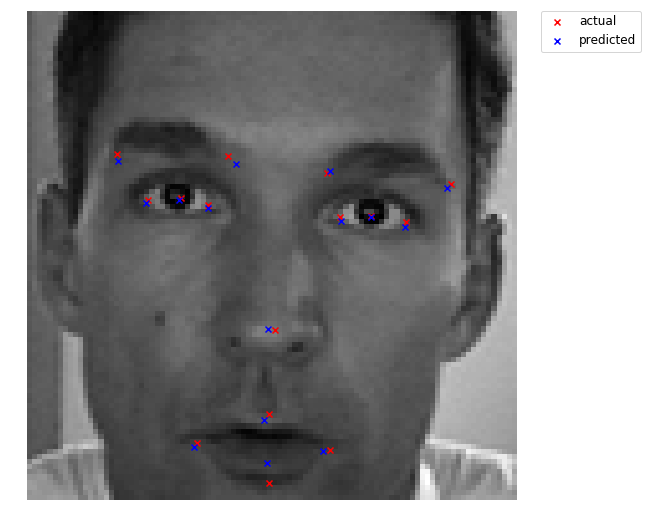

In [17]:
example_num = 25
print ('RMSE of '+ str((self.score(self.dev_labels[example_num], y_pred[example_num]))))

self.plot_example(self.dev_data[example_num], self.dev_labels[example_num], y_pred[example_num])

#### Using Flipped Images to Extend Our Training Data

In [19]:
data = np.concatenate((self.train_data, self.train_data_f))
labels = np.concatenate((self.train_labels, self.train_labels_f))

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X=data, y=labels)

print 'RMSE on Dev Data of '
y_pred = knn.predict(self.dev_data) 
self.score(self.dev_labels, y_pred)

RMSE on Dev Data of 


9.8495491412724334

Flipping the image to create more data did not improve the score.

## Neural Net

We utilized Scikit's Multilayer Perceptron Regressor for neural network regression on the training data. Attempts with Tensorflow can be found in Appendix B.

#### Standard Scale Training and Labels

To start, we trained only on the completely labeled examples with two hidden layers (1000, 500)

We used early_stopping to make training faster and also to avoid overfitting

In [20]:
data = self.train_data
labels = self.train_labels

label_scaler, data_scaler = StandardScaler(), StandardScaler()
label_scaler.fit(labels)
data_scaler.fit(data)

mlp = MLPRegressor(hidden_layer_sizes=(1000, 500), early_stopping=True, verbose=True)
mlp.fit(data_scaler.transform(data), label_scaler.transform(labels))

Iteration 1, loss = 8.28682371
Validation score: -6.559384
Iteration 2, loss = 2.88234829
Validation score: -2.861513
Iteration 3, loss = 1.73787767
Validation score: -1.564985
Iteration 4, loss = 1.15248183
Validation score: -1.568344
Iteration 5, loss = 0.95069863
Validation score: -0.829381
Iteration 6, loss = 0.77931894
Validation score: -0.562064
Iteration 7, loss = 0.62228628
Validation score: -0.283144
Iteration 8, loss = 0.47440983
Validation score: -0.150297
Iteration 9, loss = 0.45822266
Validation score: 0.060078
Iteration 10, loss = 0.34545572
Validation score: 0.035442
Iteration 11, loss = 0.30444523
Validation score: 0.100070
Iteration 12, loss = 0.27998862
Validation score: 0.185122
Iteration 13, loss = 0.23151991
Validation score: 0.221991
Iteration 14, loss = 0.21651836
Validation score: 0.249486
Iteration 15, loss = 0.21049740
Validation score: 0.289399
Iteration 16, loss = 0.18903588
Validation score: 0.188575
Iteration 17, loss = 0.20356314
Validation score: 0.16739

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(1000, 500), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [22]:
y_pred = mlp.predict(data_scaler.transform(self.dev_data))
print 'RMSE on Dev Data of '
self.score(self.dev_labels, label_scaler.inverse_transform(y_pred))

RMSE on Dev Data of 


2.5982152410568093

#### Using training data with missing Labels filled by average

In [23]:
data = self.train_data_n
labels = self.average_nans(self.train_labels_n)

label_scaler, data_scaler = StandardScaler(), StandardScaler()
label_scaler.fit(labels)
data_scaler.fit(data)

mlp = MLPRegressor(hidden_layer_sizes=(1000, 500), early_stopping=True)
mlp.fit(data_scaler.transform(data), label_scaler.transform(labels))

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(1000, 500), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [25]:
y_pred = mlp.predict(data_scaler.transform(self.dev_data))
print 'RMSE on Dev Data of '
self.score(self.dev_labels, label_scaler.inverse_transform(y_pred))

RMSE on Dev Data of 


2.605725942378375

#### Using blurring and average _nans_

In [26]:
data = self.blur_data(self.train_data_n)
labels = self.average_nans(self.train_labels_n)

label_scaler, data_scaler = StandardScaler(), StandardScaler()
label_scaler.fit(labels)
data_scaler.fit(data)

mlp_blurr = MLPRegressor(hidden_layer_sizes=(1000, 500), early_stopping=True)
mlp_blurr.fit(data_scaler.transform(data), label_scaler.transform(labels))   

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(1000, 500), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [27]:
y_pred = mlp_blurr.predict(data_scaler.transform(self.dev_data))
print 'RMSE on Dev Data of '
self.score(self.dev_labels, label_scaler.inverse_transform(y_pred))

RMSE on Dev Data of 


2.3807301847031925

#### Plot a Prediction

RMSE of 2.68375498658


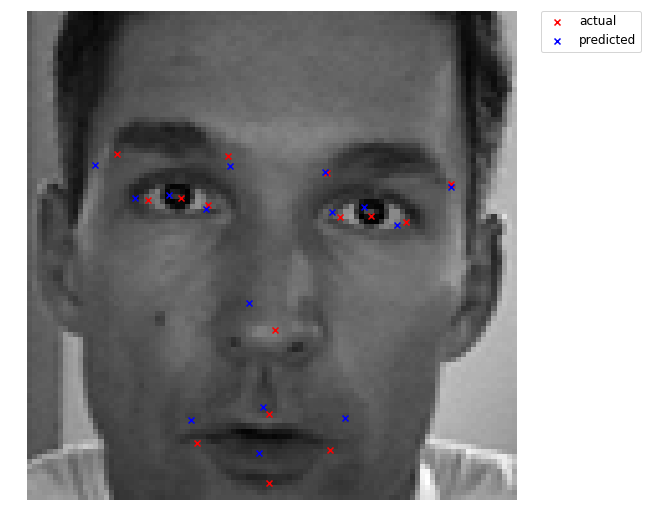

In [28]:
print 'RMSE of '+ str((self.score(self.dev_labels[example_num],
                                   label_scaler.inverse_transform(y_pred[example_num]))))

self.plot_example(self.dev_data[example_num], self.dev_labels[example_num], 
                  label_scaler.inverse_transform(y_pred[example_num]))

#### Examining our Learning Curves

In the above MLP Regression we have the following learning curve

Text(0,0.5,'Loss Function')

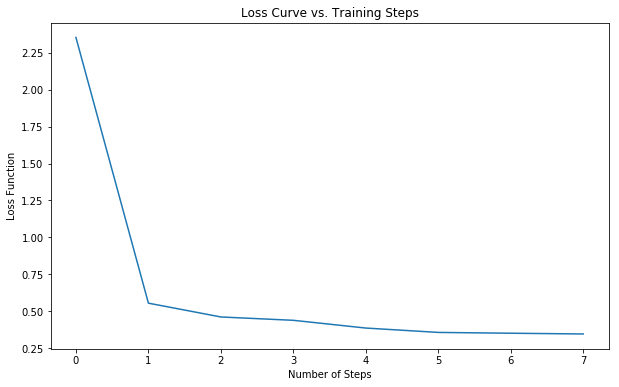

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(mlp.loss_curve_)
plt.title('Loss Curve vs. Training Steps')
plt.xlabel('Number of Steps')
plt.ylabel('Loss Function')

#### Let's examine a bit closer the Learning Curve using train_test_split

In [30]:
def plot_learning_curves(model, X, y, epoch_size=100):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    
    for m in range(1, int(X_train.shape[0]/epoch_size)):
        model.fit(X_train[:m*epoch_size], y_train[:m*epoch_size])
        y_train_predict = model.predict(X_train[:m*epoch_size])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m*epoch_size]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
        print('Training Epoch ' + str(m*epoch_size))
        
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='Training Set')
    plt.plot(np.sqrt(val_errors),    'b-', linewidth=3, label='Validation Set')
    plt.title('Loss Curve vs. Training Steps')
    plt.xlabel('Number of Steps')
    plt.ylabel('Loss Function')
    plt.legend()
    return

Training Epoch 50
Training Epoch 100
Training Epoch 150
Training Epoch 200
Training Epoch 250
Training Epoch 300
Training Epoch 350
Training Epoch 400
Training Epoch 450
Training Epoch 500
Training Epoch 550
Training Epoch 600
Training Epoch 650
Training Epoch 700
Training Epoch 750
Training Epoch 800
Training Epoch 850


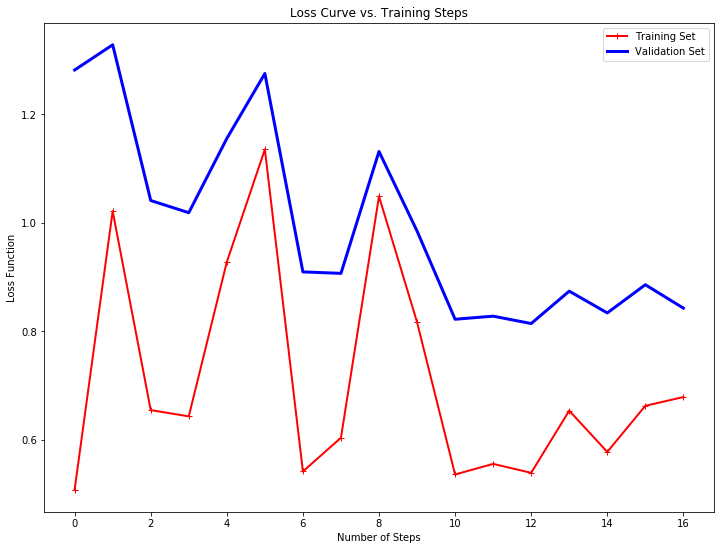

In [31]:
data = self.train_data
labels = self.train_labels

label_scaler, data_scaler = StandardScaler(), StandardScaler()
label_scaler.fit(labels)
data_scaler.fit(data)

mlp = MLPRegressor(hidden_layer_sizes=(1000, 500), early_stopping=True)

## Warning this can be very slow depending on epoch_size and training data size!!
plot_learning_curves(mlp, data_scaler.transform(data), label_scaler.transform(labels), epoch_size=50)

#### Using Flipped Images to Extend Our Training Data

Flipping the image makes the RMSE worse!

In [32]:
data = np.concatenate((self.train_data, self.train_data_f))
labels = np.concatenate((self.train_labels, self.train_labels_f))

label_scaler, data_scaler = StandardScaler(), StandardScaler()
label_scaler.fit(labels)
data_scaler.fit(data)

mlp = MLPRegressor(hidden_layer_sizes=(1000, 500), early_stopping=True)
mlp.fit(data_scaler.transform(data), label_scaler.transform(labels))   

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(1000, 500), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [34]:
print 'RMSE on Dev Data of '
y_pred = mlp.predict(data_scaler.transform(self.dev_data))
self.score(self.dev_labels, label_scaler.inverse_transform(y_pred))

RMSE on Dev Data of 


12.373261819163995

## Submissions

In [35]:
data = self.blur_data(self.train_data_n)
labels = self.average_nans(self.train_labels_n)

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X=data, y=labels)

k_nn_submission = knn.predict(self.test_data)
self.submission_gen(k_nn_submission, 'knn')

In [36]:
data = self.blur_data(self.train_data_n)
labels = self.average_nans(self.train_labels_n)

label_scaler, data_scaler = StandardScaler(), StandardScaler()
label_scaler.fit(labels)
data_scaler.fit(data)

mlp = MLPRegressor(hidden_layer_sizes=(1000, 500), early_stopping=True)
mlp.fit(data_scaler.transform(data), label_scaler.transform(labels))   

mlp_submission = mlp.predict(data_scaler.transform(self.test_data))
self.submission_gen(label_scaler.inverse_transform(mlp_submission), 'mlp')

# Appendix A

### Grid Search to Find Best Parameters

Grid searches on both the KNN regressor and the multilayer perceptron regressor are very costly in terms of time. Completing the MLPRegressor grid search was calculated to take up to 33 hours.

In [37]:
knn = KNeighborsRegressor()
parameters ={'n_neighbors': range(1, 25)}

## Warning Slow
# clf = GridSearchCV(knn, parameters)
# clf.fit(self.train_data, self.train_labels)
# clf.best_params_

In [38]:
mlp = MLPRegressor()

parameters = {'hidden_layer_sizes': [(500, 200), (1000, 500), (300, 100), (500, 300, 100)],
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'alpha': [0.0001, 0.001, 0.01, 0.005],
              'learning_rate': ['constant', 'adaptive'],
              'learning_rate_init': [0.001, 0.005, 0.01, 0.0001],
              'early_stopping': ['True']
              }


## Warning this is VERY SLOW
# clf = GridSearchCV(mlp, parameters)
# clf.fit(self.train_data, self.train_labels)
# clf.best_params_

# Appendix B
Attempts were made with Tensorflow starting with linear regression, then logistics regression, with the goal of transforming the logistic regression model into a mulitlayer neural network. The challenge was in the amount of time needed to build the model as well as incorporating 30 points to be classified. Below are the results of classifying on just one facial keypoint.

## Linear Regression

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from IPython.display import display, clear_output 
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import time
import csv
%matplotlib inline

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


#### Import and Format Data

In [4]:
# import training.csv which contains a header row of face locations and 'image,' the column of lists of pixel values
with open("training.csv") as f:
    train_import = list(csv.reader(f))

# shuffle the data    
removed_header = train_import[1:]
shuffle = np.random.permutation(np.arange(len(removed_header)))
shuffled_train_import = [removed_header[i] for i in shuffle]
    
# divide the rows 80% for training and 20% for development    
train_portion = int(.8*(len(shuffled_train_import)))
dev_portion = len(shuffled_train_import) - train_portion

# extract training and development data
train_data = shuffled_train_import[:train_portion]
dev_data = shuffled_train_import[-dev_portion:]

# initialize the list of lists of pixel values 
train_image_data = []

# convert each list of pixel values (1 per row) to integers (first split the string up then convert each elem to int)
for row in range(len(train_data)):
    train_image_data.append([int(i) for i in list(train_data[row][30].split())])
# convert to a numpy array
train_image_data = np.array(train_image_data)

# convert range of 0 to 255 for pixel values to 0 to 1 (0 = white, 1 = black)
train_image_data = train_image_data/255.0
    
# initialize array of the 30 different facial location target values (labels) for each example image
train_image_labels = np.empty((len(train_data), 30))

# iterate through each row and each example image's 30 target facial locations and covert to floats or NaNs
for i in range(len(train_data)):
    for j in range(len(train_data[i][0:30])):
        if train_data[i][j] == '':
            train_image_labels[i][j] = float('nan')
        else: 
            train_image_labels[i][j] = (float(train_data[i][j]))

#### Remove Rows with NaN Target Values

In [5]:
# remove rows where 'left_eye_center_x' == NaN values from the training and label data
non_NaN_list = np.invert((np.isnan(train_image_labels[:,0])))
cln_train_image_data = train_image_data[non_NaN_list]
cln_train_image_labels = train_image_labels[non_NaN_list]

#### Linear Regression - Facial Recognition

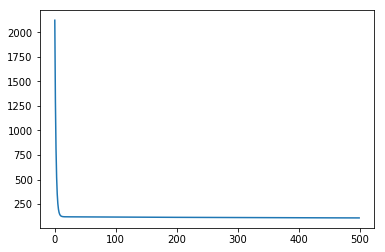

In [6]:
tf.reset_default_graph()
trainX = tf.constant(cln_train_image_data, dtype = tf.float32)
# only attempting 1 out of 30 facial locations (column 0), 'left_eye_center_x'
trainY = tf.constant(cln_train_image_labels[:,0], dtype = tf.float32)
learningRate = tf.constant(0.0001)
# create beta variable (vector of 9216 beta values: 1 for each pixel)
beta = tf.get_variable('beta', initializer=np.zeros((9216,1), dtype = np.float32))

def model(this_beta, x):
    return tf.matmul(x, this_beta)

def cost(this_beta):
    ans = tf.reduce_mean((model(this_beta, trainX) - trainY)**2) / 2
    return ans

cc = cost(beta)

## Gradient descent by tensorflow
gd = tf.train.GradientDescentOptimizer(learningRate)
step = gd.minimize(cost(beta))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    cost_vec = []
    # By running step multiple times, we perform gradient descent for the variable beta. 
    # For each step, we can ouput the cost function.
    for i in range(500):
        _, cost = sess.run([step, cc])
        cost_vec.append(cost)
        my_beta = sess.run([beta])[0]
    plt.plot(cost_vec)

#### Test the Betas with the Development Data

In [7]:
'''REPEATING SAME TREATMENT OF DATA THAT WAS DONE TO THE TRAINING PORTION'''
# initialize the development list of lists of pixel values 
dev_image_data = []

# convert each list of pixel values (1 per row) to integers (first split the string up then convert each elem to int)
for row in range(len(dev_data)):
    dev_image_data.append([int(i) for i in list(dev_data[row][30].split())])
# convert to a numpy array
dev_image_data = np.array(dev_image_data)

# convert range of 0 to 255 for pixel values to 0 to 1 (0 = white, 1 = black)
dev_image_data = dev_image_data/255.0

# initialize array of the 30 different facial location target values (labels) for each example image
dev_image_labels = np.empty((len(dev_data), 30))

# iterate through each row and each example image's 30 target facial locations and covert to floats or NaNs
for i in range(len(dev_data)):
    for j in range(len(dev_data[i][0:30])):
        if dev_data[i][j] == '':
            dev_image_labels[i][j] = float('nan')
        else: 
            dev_image_labels[i][j] = (float(dev_data[i][j]))

#### Remove Rows with NaN Target Values

In [8]:
# remove rows where 'left_eye_center_x' == NaN values from the dev and dev_label data
non_NaN_list = np.invert((np.isnan(dev_image_labels[:,0])))
cln_dev_image_data = dev_image_data[non_NaN_list]
cln_dev_image_labels = dev_image_labels[non_NaN_list]

#### Calculate RMSE from Development Data

In [9]:
# determine predicted x-coordiate for 'left_eye_center_x', named y_hat to match RMSE formula in Kaggle competition
y_hat = np.matmul(cln_dev_image_data, my_beta)

# y represents the original coordinate for left_eye_center_x'
y = cln_dev_image_labels[:,0]

n = len(y)

# root mean squared error
rmse = np.sqrt(np.sum((y[0] - y_hat)**2)/float(n))

print(rmse)

14.4255290015


## Logistic Regression

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from IPython.display import display, clear_output 
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import time
import csv
%matplotlib inline

#### Import and Format Data

In [11]:
# import training.csv which contains a header row of face locations and 'image,' the column of lists of pixel values
with open("training.csv") as f:
    train_import = list(csv.reader(f))

# shuffle the data    
removed_header = train_import[1:]
shuffle = np.random.permutation(np.arange(len(removed_header)))
shuffled_train_import = [removed_header[i] for i in shuffle]
    
# divide the rows 80% for training and 20% for development    
train_portion = int(.8*(len(shuffled_train_import)))
dev_portion = len(shuffled_train_import) - train_portion

# extract training and development data
train_data = shuffled_train_import[:train_portion]
dev_data = shuffled_train_import[-dev_portion:]

In [12]:
'''GET TRAINING PIXEL VALUES AND TARGET DATA INTO USABLE NUMPY ARRAYS'''
# initialize the list of lists of pixel values 
train_image_data = []

# convert each list of pixel values (1 per row) to integers (first split the string up then convert each elem to int)
for row in range(len(train_data)):
    train_image_data.append([int(i) for i in list(train_data[row][30].split())])
# convert to a numpy array
train_image_data = np.array(train_image_data)

# convert range of 0 to 255 for pixel values to 0 to 1 (0 = white, 1 = black)
train_image_data = train_image_data/255.0
    
# initialize array of the 30 different facial location target values (labels) for each example image
train_image_labels = np.empty((len(train_data), 30))

# iterate through each row and each example image's 30 target facial locations and covert to floats or NaNs
for i in range(len(train_data)):
    for j in range(len(train_data[i][0:30])):
        if train_data[i][j] == '':
            train_image_labels[i][j] = float('nan')
        else: 
            train_image_labels[i][j] = float(train_data[i][j])

In [13]:
'''REPEATING SAME TREATMENT OF DATA THAT WAS DONE TO THE TRAINING PORTION'''
# initialize the development list of lists of pixel values 
dev_image_data = []

# convert each list of pixel values (1 per row) to integers (first split the string up then convert each elem to int)
for row in range(len(dev_data)):
    dev_image_data.append([int(i) for i in list(dev_data[row][30].split())])
# convert to a numpy array
dev_image_data = np.array(dev_image_data)

# convert range of 0 to 255 for pixel values to 0 to 1 (0 = white, 1 = black)
dev_image_data = dev_image_data/255.0

# initialize array of the 30 different facial location target values (labels) for each example image
dev_image_labels = np.empty((len(dev_data), 30))

# iterate through each row and each example image's 30 target facial locations and covert to floats or NaNs
for i in range(len(dev_data)):
    for j in range(len(dev_data[i][0:30])):
        if dev_data[i][j] == '':
            dev_image_labels[i][j] = float('nan')
        else: 
            dev_image_labels[i][j] = (float(dev_data[i][j]))

In [14]:
# characterizing data set
numFeatures = train_image_data[1].size
numClasses = 96
numTrainExamples = train_image_data.shape[0]
numDevExamples = dev_image_data.shape[0]
print('Features = %d' %(numFeatures))
print('Train set = %d' %(numTrainExamples))
print('Dev set = %d' %(numDevExamples))

Features = 9216
Train set = 5639
Dev set = 1410


#### Remove Rows with NaN Target Values

In [15]:
# remove rows where 'left_eye_center_x' == NaN values from the training and label data
non_NaN_list = np.invert((np.isnan(train_image_labels[:,0])))
cln_train_image_data = train_image_data[non_NaN_list]
cln_train_image_labels = train_image_labels[non_NaN_list]

# remove rows where 'left_eye_center_x' == NaN values from the dev and dev_label data
non_NaN_list = np.invert((np.isnan(dev_image_labels[:,0])))
cln_dev_image_data = dev_image_data[non_NaN_list]
cln_dev_image_labels = dev_image_labels[non_NaN_list]

#### Logistic Regression - Facial Recognition

In [16]:
# (1) Parameters

tf.reset_default_graph()

# Constants
devY = tf.one_hot(np.rint(cln_dev_image_labels[:,0]), numClasses)
devX = tf.constant(cln_dev_image_data, dtype = tf.float32)

# placeholders
# In Tensorflow, placeholder are prepared to be filled with different python objects in the session.
# Using these placeholder, we don't need to transform the python objects train_data and train_labels into 
# Tensorflow object. tf.placeholder does this for us.
x_ = tf.placeholder(tf.float32, shape=[None, numFeatures], name='x')
y_ = tf.placeholder(tf.int32, shape=[None], name='y')

# and Variables
w = tf.get_variable('w', shape=[numFeatures, numClasses])

In [17]:
# (2) Model

def model(input_layer):
    output_layer = tf.nn.softmax(tf.matmul(input_layer, w))
    return output_layer

In [18]:
# (3) Cost

def cost_func(data, labels):
    cc = tf.losses.mean_squared_error(labels, model(data))
    return  cc

In [ ]:
# (4) Ojbective (and solver)
y_one_hot = tf.one_hot(y_, numClasses)
cc = cost_func(x_, y_one_hot)
gd = tf.train.GradientDescentOptimizer(learning_rate=0.01)
step = gd.minimize(cc)
dev_preds = model(devX)

miniBatchSize = 10;
num_samples = train_image_data.shape[0]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    cost_vec = []
    for i in range(80):
        for start, end in zip(range(0, num_samples, miniBatchSize), range(miniBatchSize, num_samples, miniBatchSize)):
            batch = cln_train_image_data[start:end], np.rint(cln_train_image_labels[:,0][start:end])
            # If we run step in the session, we specify x_ and y_ by using fed_dict as argument
            _, cost, dev__preds = sess.run([step, cc, dev_preds], feed_dict={x_: batch[0], y_: batch[1]})
        cost_vec.append(cost)
        clear_output(wait=True)
        # determine predicted x-coordiate for 'left_eye_center_x', named y_hat to match RMSE formula in competition
        y_hat = np.argmax(dev__preds, axis=1)
        # y represents the original coordinate for left_eye_center_x'
        y = cln_dev_image_labels[:,0]
        n = len(y)
        # root mean squared error
        rmse = np.sqrt(np.sum((y - y_hat)**2)/float(n))
        print('%d) RMSE = %.4f' %(i+1, rmse))
    
plt.plot(cost_vec)  
plt.xlabel('Number of Gradient Descent steps')
plt.ylabel('Cost function')
plt.show()

74) RMSE = 3.5360


# Having Some Fun!

Try a 96 pixel by 96 pixel greyscale JPEG yourself.

In [34]:
im = imageio.imread('noah.jpg')

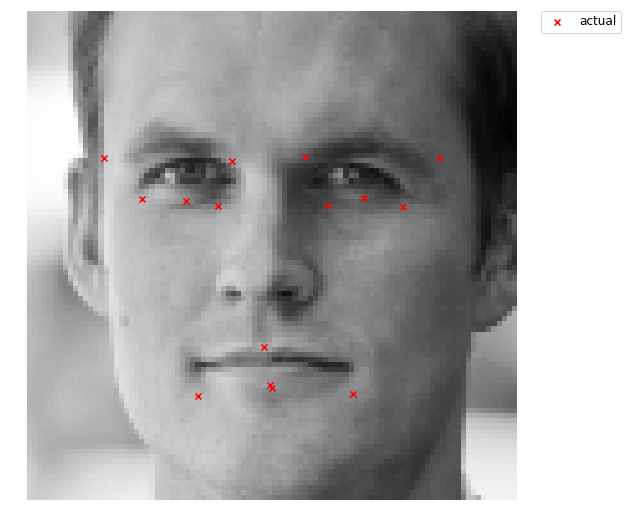

In [35]:
harry_labels_mlp = mlp_blurr.predict(data_scaler.transform(self.rgb2gray(im).reshape(1, 9216)/255.0))
self.plot_example(self.rgb2gray(im)/255.0, label_scaler.inverse_transform(harry_labels_mlp).flatten())